In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from theano import shared
import theano.tensor as T
from pymc3 import *
import warnings
warnings.filterwarnings('ignore')

In [48]:
#Importing dataset
df = pd.read_csv('breast-cancer-wisconsin.csv')
df.drop(['id'],1,inplace=True)

# Convert '?' to NaN
df[df == '?'] = np.nan
# Drop missing values and print shape of new DataFrame
df = df.dropna()

X = scale(np.array(df.drop(['class'],1)))
y = np.array(df['class'])/2-1

#Split Data
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2, random_state=42)

#Sharedvariable
model_input = shared(X_tr)
model_output= shared(y_tr)

In [46]:
#Generate Model
logistic_model = pm.Model()
with logistic_model:
    # Priors for unknown model parameters    
    alpha = pm.Normal("alpha", mu=0,sd=1)
    betas = pm.Normal("betas", mu=0, sd=1, shape=X.shape[1])
    
    # Expected value of outcome
    p = pm.invlogit(alpha + T.dot(model_input,betas))
    

    # Likelihood (sampling distribution of observations)
    y = pm.Bernoulli('y', p, observed=model_output)

In [47]:
#infering parameters
with logistic_model:
    advi=pm.ADVI()
    approx = advi.fit(n=10000,more_replacements={
        model_input:pm.Minibatch(X_tr),
        model_output:pm.Minibatch(y_tr)
    
     }
        )

Average Loss = 18.953: 100%|█████████████████████████████████████████████████████| 10000/10000 [10:16<00:00, 16.21it/s]
Finished [100%]: Average Loss = 18.953


Average Loss = 56.92: 100%|██████████████████████████████████████████████████████| 10000/10000 [19:45<00:00,  8.44it/s]
Finished [100%]: Average Loss = 56.919


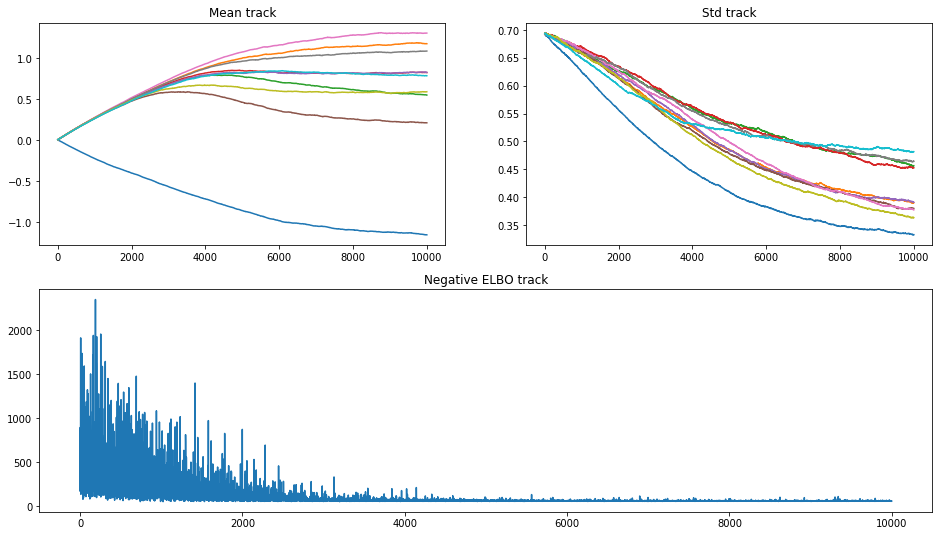

In [53]:
with logistic_model:

    advi=pm.ADVI()
    advi.approx.mean.eval()
    advi.approx.std.eval()

    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
    )
    approx = advi.fit(10000, callbacks=[tracker])
    
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

In [54]:
#for RV in logistic_model.basic_RVs:
    #print(RV.name, RV.logp(logistic_model.test_point))
    #print(p.tag.test_value)

alpha -0.9189385332046727
betas -8.270446798842054
y -378.45836058573013


              mean        sd  mc_error   hpd_2.5  hpd_97.5
alpha    -1.161321  0.334630  0.003659 -1.781789 -0.463087
betas__0  1.172359  0.387854  0.004348  0.389210  1.904400
betas__1  0.546716  0.454551  0.005015 -0.339006  1.427303
betas__2  0.815957  0.452364  0.004049 -0.098494  1.668984
betas__3  0.826157  0.388835  0.003670  0.045017  1.570793
betas__4  0.205805  0.379913  0.003621 -0.558134  0.930207
betas__5  1.305499  0.380913  0.003811  0.561492  2.053063
betas__6  1.092242  0.461337  0.004974  0.178509  1.981741
betas__7  0.578646  0.364641  0.003511 -0.134965  1.286797
betas__8  0.781196  0.484639  0.004202 -0.154469  1.737607


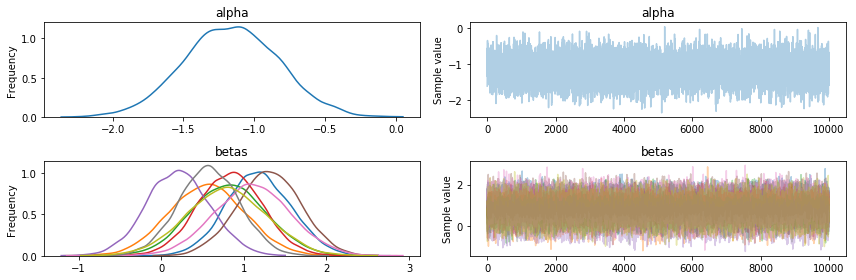

In [55]:
#Intrepreting parameters
trace = approx.sample(draws=10000)
print(pm.summary(trace))

pm.plots.traceplot(trace)
plt.show()

In [99]:
#Replace shared variable with testing set
model_input.set_value(X_te)
model_output.set_value(y_te)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace,model=logistic_model,samples=1000)

pred = ppc['y'].mean(axis=0) > 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.89it/s]


In [103]:
print(y_tr.shape)
print(X_te.shape)
print(y_te.shape)
print(pred.shape)

print('Accuracy = {}%'.format((y_te == pred).mean() * 100))

(546,)
(137, 9)
(137,)
(546,)


AttributeError: 'bool' object has no attribute 'mean'